# Load Data

In [1]:
import pandas as pd


In [113]:

# Load Gold H1 data
data = pd.read_csv('data.csv')

# Set date oclumn to datetime
data['Local time'] = pd.to_datetime(
    data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', utc=True)

# change local time name to date
data.rename(columns={'Local time': 'Date'}, inplace=True)

# set index to date
data.set_index('Date', inplace=True)

# drop rows with volume = 0
data = data[data['Volume'] != 0]

# print first 5 rows
print(len(data))
data.head()


31890


,Open,High,Low,Close,Volume
Date,,,,,
2018-01-01 23:00:00+00:00,1302.922,1307.602,1302.231,1306.711,1.626430e+06
2018-01-02 00:00:00+00:00,1306.711,1307.308,1305.211,1306.292,2.392190e+06
2018-01-02 01:00:00+00:00,1306.291,1306.952,1304.171,1306.141,2.997380e+06
2018-01-02 02:00:00+00:00,1306.142,1306.772,1305.418,1305.949,2.441420e+06
2018-01-02 03:00:00+00:00,1305.941,1307.422,1305.381,1306.438,2.557650e+06


In [71]:
! pip install ta

# ZigZag Indicator

In [114]:
import numpy as np
import ta

def time_price_distance(v1, v2, t1, t2, atr):
    return abs(v2 - v1) / atr + abs(t2 - t1) / 4

def extract_async_peaks(data, left_alpha, right_alpha, atr_window, arrow_margin_plot_coef=0.5):
    # Intialize max_peaks and min_peaks with NaN
    max_peaks, min_peaks = [np.nan]*len(data), [np.nan]*len(data)

    # Extract local max peaks
    for i in range(atr_window, len(data)):
        atr = data['ATR'][i]
        is_max = True
        # Right side check
        for j in range(i+1, len(data)):
            if data['High'][j] > data['High'][i]:
                is_max = False
                break
            if time_price_distance(data['High'][i], data['Low'][j], i, j, atr) > right_alpha:
                break
        # Left side check
        if is_max:
            for j in range(i-1, 0, -1):
                if data['High'][j] > data['High'][i]:
                    is_max = False
                    break
                if time_price_distance(data['High'][i], data['Low'][j], i, j, atr) > left_alpha:
                    break
        if is_max:
            max_peaks[i] = data['High'][i] + arrow_margin_plot_coef * atr

    # Extract local min peaks
    for i in range(atr_window, len(data)):
        atr = data['ATR'][i]
        is_min = True
        # Right side check
        for j in range(i+1, len(data)):
            if data['Low'][j] < data['Low'][i]:
                is_min = False
                break
            if time_price_distance(data['Low'][i], data['High'][j], i, j, atr) > right_alpha:
                break
        # Left side check
        if is_min:
            for j in range(i-1, 0, -1):
                if data['Low'][j] < data['Low'][i]:
                    is_min = False
                    break
                if time_price_distance(data['Low'][i], data['High'][j], i, j, atr) > left_alpha:
                    break
        if is_min:
            min_peaks[i] = data['Low'][i] - arrow_margin_plot_coef * atr

    # remove peaks that are in a sequence
    for i in range(atr_window, len(data)):
        if not np.isnan(max_peaks[i]):
            # check for next peak (it sould be a min peak)
            for j in range(i+1, len(data)):
                if np.isnan(max_peaks[j]):
                    break
                if not np.isnan(max_peaks[j]):
                    max_peaks[j] = np.nan
        if not np.isnan(min_peaks[i]):
            # check for next peak (it sould be a max peak)
            for j in range(i+1, len(data)):
                if np.isnan(min_peaks[j]):
                    break
                if not np.isnan(min_peaks[j]):
                    min_peaks[j] = np.nan

    # remove peaks in a same candle
    for i in range(atr_window, len(data)):
        if not np.isnan(max_peaks[i]) and not np.isnan(min_peaks[i]):
            if data['Close'][i] > data['Open'][i]:
                min_peaks[i] = np.nan
            else:
                max_peaks[i] = np.nan

    return max_peaks, min_peaks

def extract_middle_paeks(data, alpha, atr_window, arrow_margin_plot_coef=0.5):
    # Intialize max_peaks and min_peaks with NaN
    max_middle_peaks, min_middle_peaks = extract_async_peaks(data, alpha, alpha, atr_window, arrow_margin_plot_coef=0.5)

    # fill between middle peaks
    for i in range(atr_window, len(data)):
        if not np.isnan(max_middle_peaks[i]):
            # check for next peak (it sould be a min peak)
            for j in range(i+1, len(data)):
                if not np.isnan(max_middle_peaks[j]):
                    # find min index between i and j
                    min_index = np.argmin(data['Low'][i+1:j]) + i+1
                    min_middle_peaks[min_index] = data['Low'][min_index] - arrow_margin_plot_coef * data['ATR'][min_index]
                    break
                if not np.isnan(min_middle_peaks[j]):
                    break
        if not np.isnan(min_middle_peaks[i]):
            # check for next peak (it sould be a max peak)
            for j in range(i+1, len(data)):
                if not np.isnan(min_middle_peaks[j]):
                    # find max index between i and j
                    max_index = np.argmax(data['High'][i+1:j]) + i+1
                    max_middle_peaks[max_index] = data['High'][max_index] + arrow_margin_plot_coef * data['ATR'][max_index]
                    break
                if not np.isnan(max_middle_peaks[j]):
                    break

    return max_middle_peaks, min_middle_peaks

def extract_list_of_lines(data):
    lines = []
    trends = []
    start_point, end_point = None, None
    trend = 'w'
    for i in range(len(data)):
        if not np.isnan(data['MaxMiddlePeaks'][i]):
            if end_point is not None:
                start_point = end_point
            end_point = (data.index[i], data['High'][i])
            if start_point is not None:
                lines.append([start_point, end_point])
                trends.append(trend)
        if not np.isnan(data['MinMiddlePeaks'][i]):
            if end_point is not None:
                start_point = end_point
            end_point = (data.index[i], data['Low'][i])
            if start_point is not None:
                lines.append([start_point, end_point])
                trends.append(trend)
        if not np.isnan(data['MaxPeaks'][i]):
            trend = 'b'
        elif not np.isnan(data['MinPeaks'][i]):
            trend = 'r'
    return lines, trends

atr_window = 200
left_alpha = 10
right_alpha = 2
arrow_margin_plot_coef = 0.5

data['ATR'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'], window=atr_window, fillna=False)
data['MaxPeaks'], data['MinPeaks'] = extract_async_peaks(data, left_alpha, right_alpha, atr_window, arrow_margin_plot_coef)
data['MaxMiddlePeaks'], data['MinMiddlePeaks'] = extract_middle_paeks(data, right_alpha, atr_window, arrow_margin_plot_coef)

In [ ]:
! pip install mplfinance

# Plot

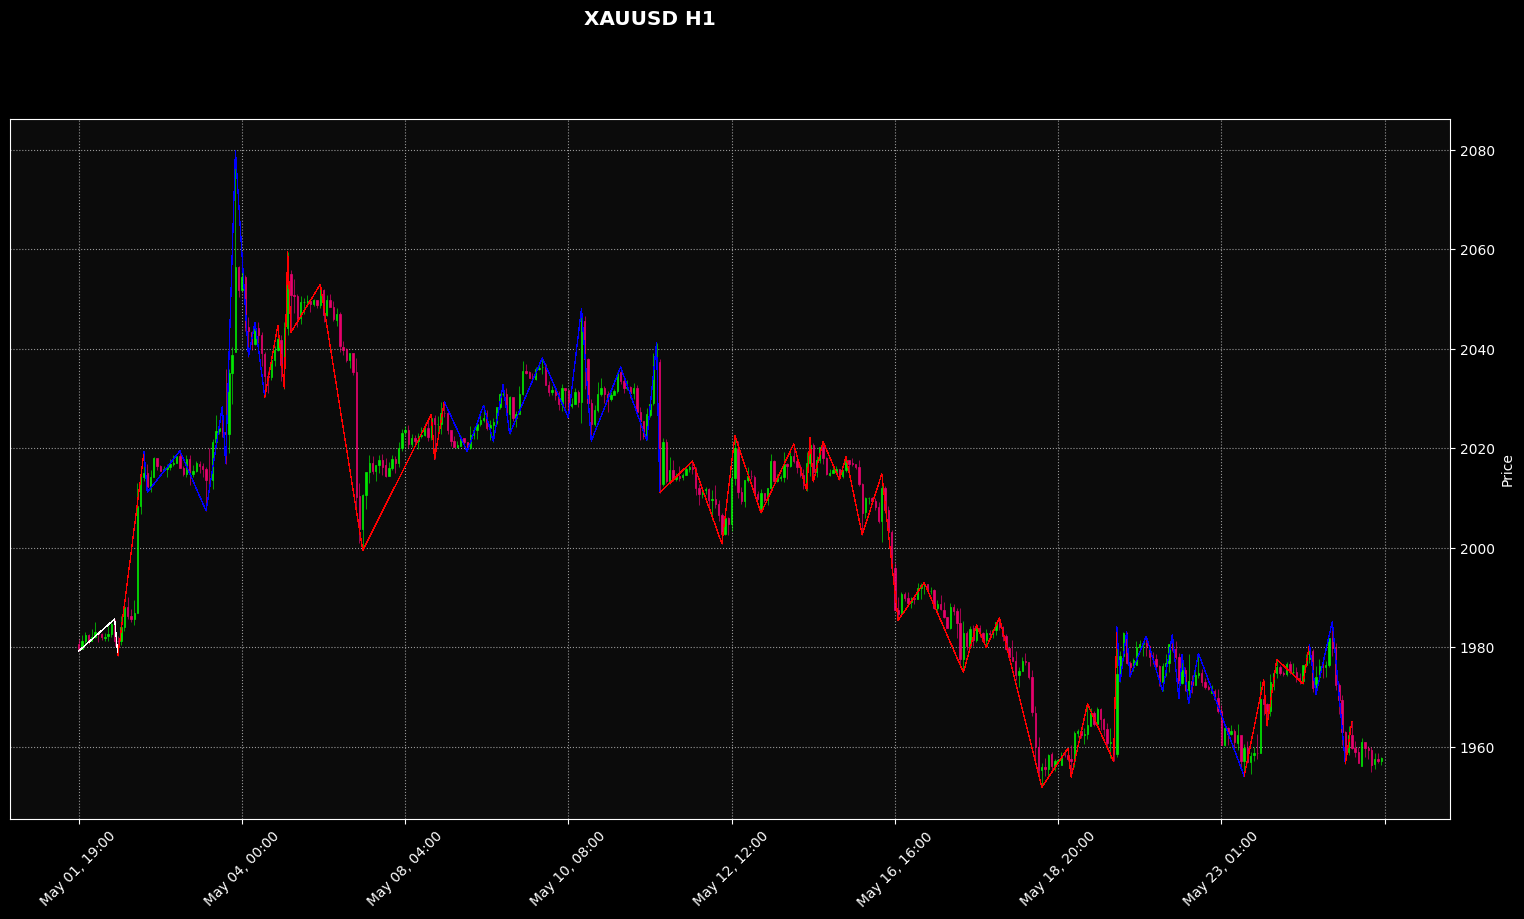

In [ ]:
import mplfinance as mpf

data_window = 400
strat_candle = 1

# ZigZag Lines
zigzag_lines, trends = extract_list_of_lines(data[-strat_candle-data_window:-strat_candle])

# create custom style
mc = mpf.make_marketcolors(up='#00ff00',down='#ff0077',inherit=True)
s = mpf.make_mpf_style(base_mpf_style='nightclouds', marketcolors=mc, gridstyle=':', y_on_right=True)
# plot candlestick chart
title = 'XAUUSD H1'
mpf.plot(data[-strat_candle-data_window:-strat_candle], type='candle', style=s, title=title, figsize=(20, 10), figscale=1,
          alines=dict(alines = zigzag_lines, colors = trends, linewidths=0.2))

In [146]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
data_window = 400
strat_candle = 1

# ZigZag Lines
zigzag_lines, trends = extract_list_of_lines(
    data[-strat_candle-data_window:-strat_candle])
def extract_legs(zigzag_lines, trends):
    legs = []
    for i in range(len(zigzag_lines)):
        start_date, start_price = zigzag_lines[i][0]
        end_date, end_price = zigzag_lines[i][1]
        trend = trends[i]
        leg = [start_date, end_date, start_price, end_price, trend]
        legs.append(leg)
    return legs

# Extract legs from Zigzag lines and trends
legs = extract_legs(zigzag_lines, trends)

# Create datasets for previous 2, 3, and 4 legs

datasets = {}
for num_legs in [2, 3, 4]:
    dataset = []
    for i in range(num_legs, len(legs)):
        instance = []
        for j in range(num_legs):
            instance += legs[i-j][2:3]
        instance += legs[i][3:]
        dataset.append(instance)
    datasets[num_legs] = np.array(dataset)

In [147]:
def KMeans_imp(n, n2, cluster=5):
    data = np.array(datasets[n])

    b_trend_data = data[data[:, n2] == 'b']
    r_trend_data = data[data[:, n2] == 'r']

    r_X = r_trend_data[:, :n2]
    r_kmeans = KMeans(n_clusters=cluster)
    r_labels = r_kmeans.fit_predict(r_X)
    r_centers = r_kmeans.cluster_centers_

    b_X = b_trend_data[:, :n2]
    b_kmeans = KMeans(n_clusters=cluster)
    b_labels = b_kmeans.fit_predict(b_X)
    b_centers = b_kmeans.cluster_centers_

    fig, axs = plt.subplots(1, cluster, figsize=(15, 5))
    fig.suptitle(f'Blue Trend Patterns')
    i = 0
    for c in b_centers:
        axs[i].plot(c, color='b')
        i += 1
    plt.show()

    fig, axs = plt.subplots(1, cluster, figsize=(15, 5))
    fig.suptitle(f'Red Trend Patterns')
    i = 0
    for c in r_centers:
        axs[i].plot(c, color='r')
        i += 1
    plt.show()


c:\Users\Alireza Nasoodi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Alireza Nasoodi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


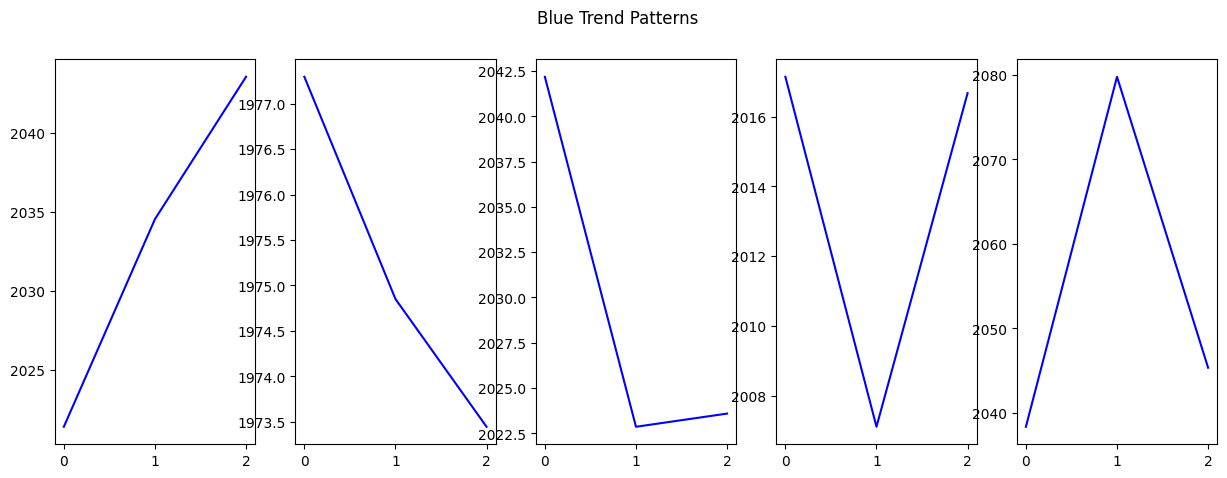

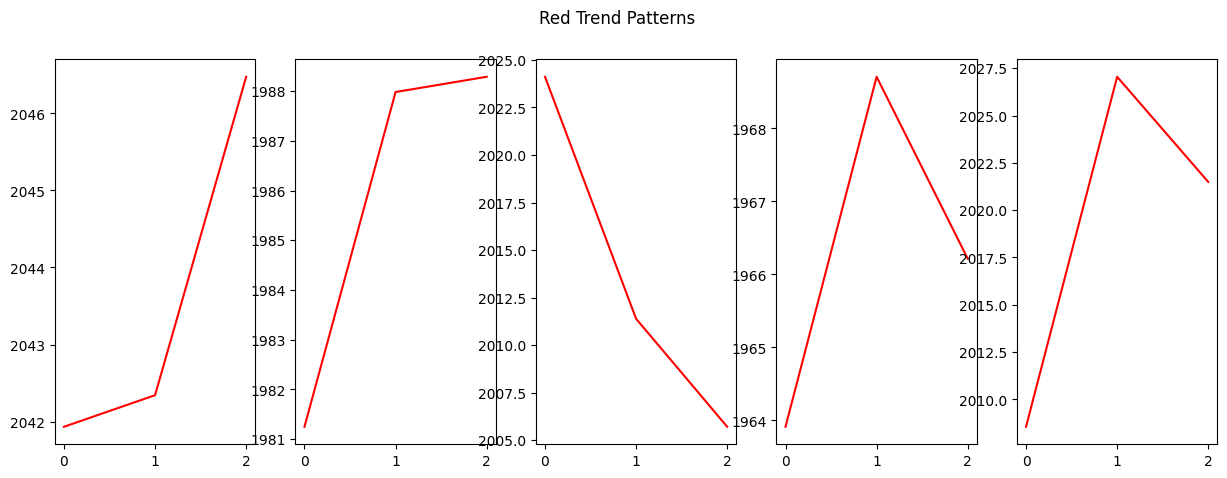

In [148]:
KMeans_imp(2,3)

c:\Users\Alireza Nasoodi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Alireza Nasoodi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


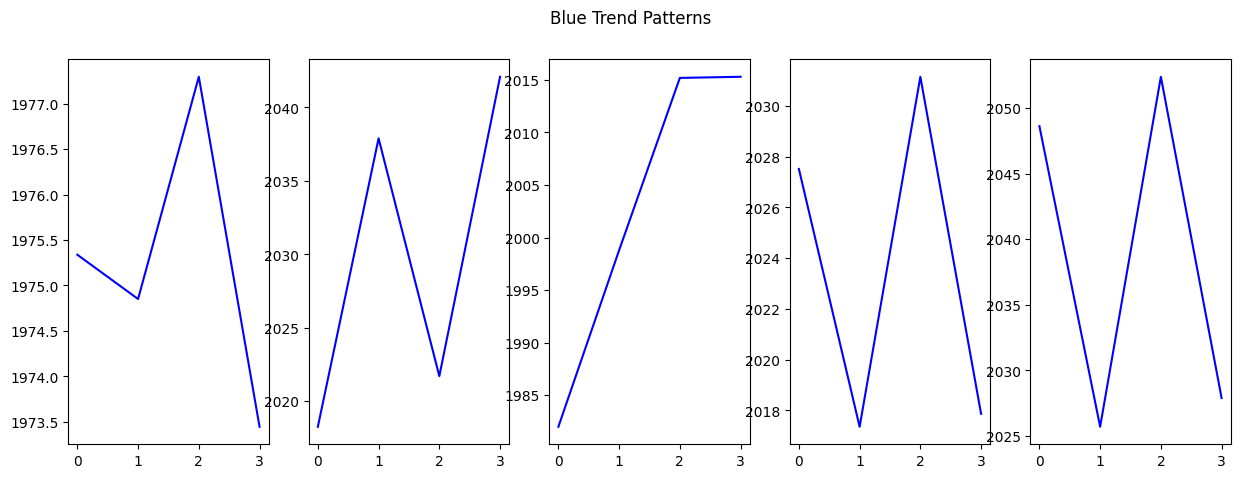

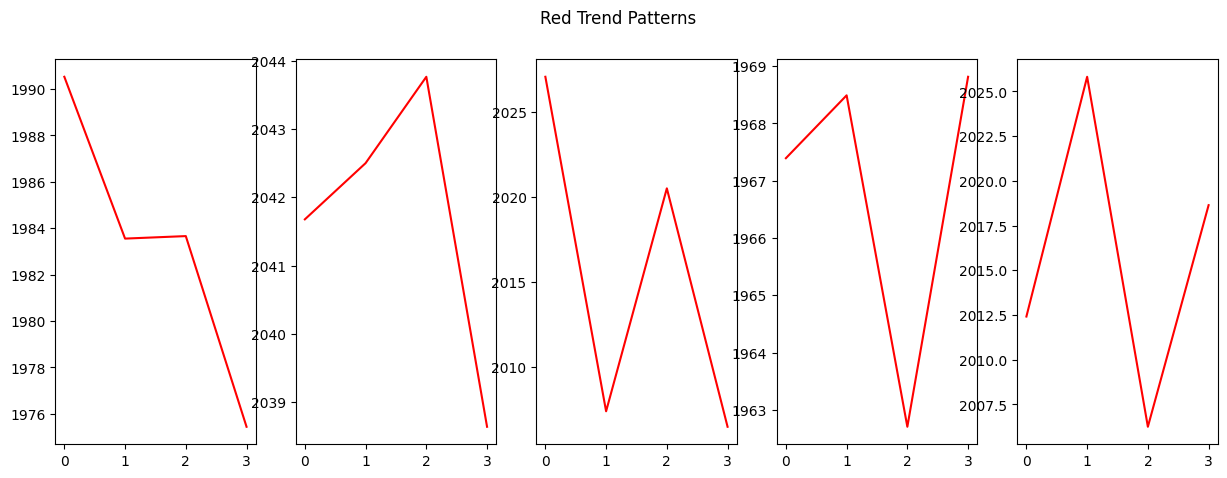

In [31]:
KMeans_imp(3,4)

c:\Users\Alireza Nasoodi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Alireza Nasoodi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


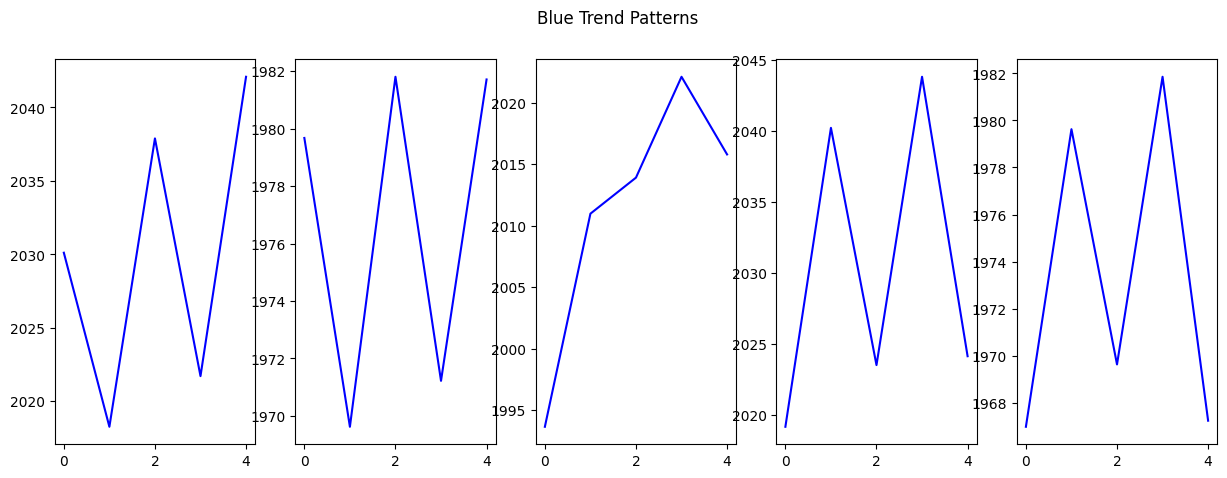

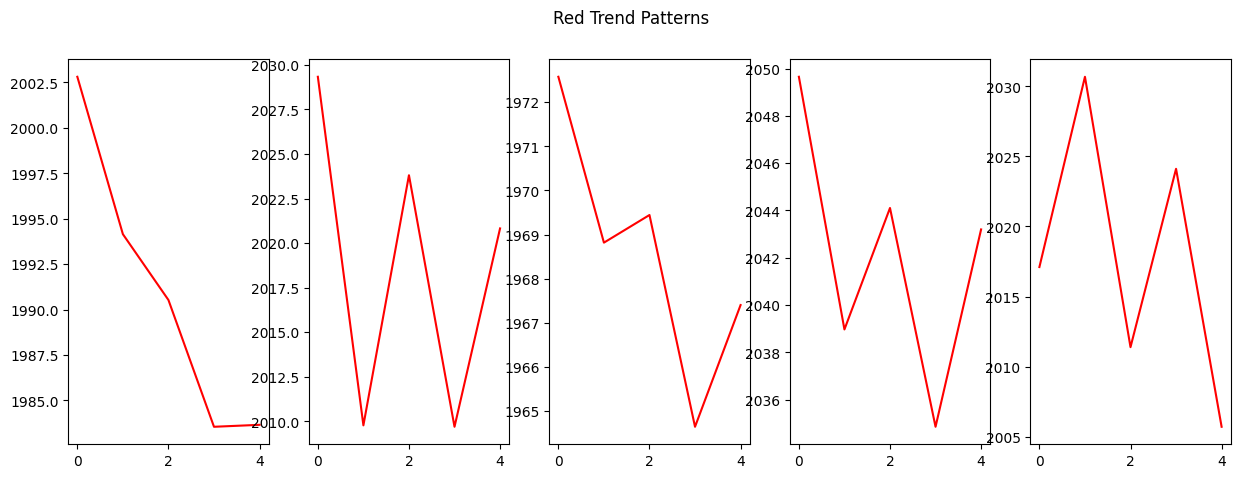

In [32]:
KMeans_imp(4,5)

[[1978.324 2019.248]
 [2019.248 2011.115]
 [2011.115 2019.465]
 [2019.465 2007.414]
 [2007.414 2028.465]
 [2028.465 2016.905]
 [2016.905 2079.778]
 [2079.778 2038.345]
 [2038.345 2045.335]
 [2045.335 2030.214]
 [2030.214 2044.734]
 [2044.734 2031.904]
 [2031.904 2059.525]
 [2059.525 2043.285]
 [2043.285 2052.925]
 [2052.925 1999.455]
 [1999.455 2026.824]
 [2026.824 2017.804]
 [2017.804 2029.334]
 [2029.334 2019.344]
 [2019.344 2028.644]
 [2028.644 2021.344]
 [2021.344 2032.754]
 [2032.754 2022.864]
 [2022.864 2038.144]
 [2038.144 2026.138]
 [2026.138 2048.114]
 [2048.114 2021.434]
 [2021.434 2036.325]
 [2036.325 2021.594]
 [2021.594 2041.214]
 [2041.214 2011.044]
 [2011.044 2017.435]
 [2017.435 2000.825]
 [2000.825 2022.494]
 [2022.494 2006.998]
 [2006.998 2020.834]
 [2020.834 2011.424]
 [2011.424 2022.114]
 [2022.114 2013.224]
 [2013.224 2021.335]
 [2021.335 2013.644]
 [2013.644 2018.235]
 [2018.235 2002.604]
 [2002.604 2014.824]
 [2014.824 1985.405]
 [1985.405 1992.985]
 [1992.985 19

c:\Users\Alireza Nasoodi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


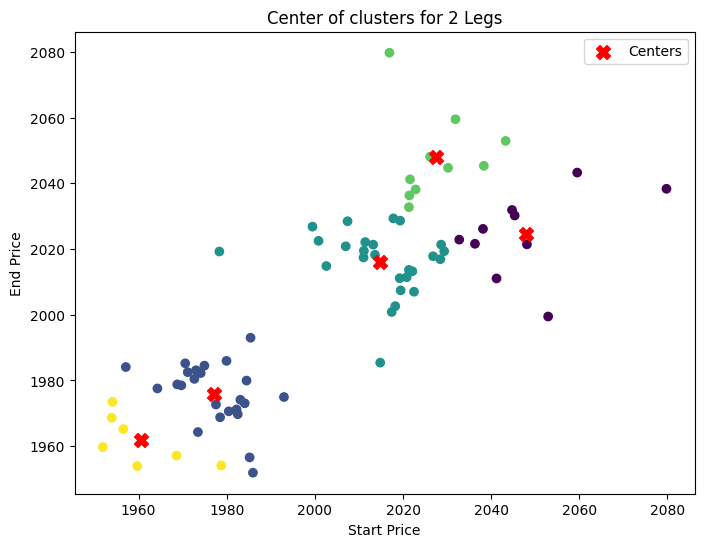

In [144]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

num_clusters = 5

# Run K-means and plot patterns for each dataset
for num_legs, dataset in datasets.items():
    if num_legs == 2:
        # Use only start price and end price for clustering
        X = dataset[:, [0, 2]].astype(float)
        print(X)
        kmeans = KMeans(n_clusters=num_clusters)
        labels = kmeans.fit_predict(X)
        centers = kmeans.cluster_centers_

        # Plot center movement
        plt.figure(figsize=(8, 6))
        plt.title(f'Center of clusters for {num_legs} Legs')
        plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
        plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=100, label='Centers')
        plt.xlabel('Start Price')
        plt.ylabel('End Price')
        plt.legend()
        plt.show()


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

num_clusters = 5
centershistory={}
# Run K-means and plot patterns for each dataset
for num_legs, dataset in datasets.items():
    if num_legs == 2:
        X = dataset[:, 2:4]  # Use only start price and end price for clustering
        for i in range(1, 101):
          kmeans = KMeans(n_clusters=num_clusters, max_iter=i)
          labels = kmeans.fit_predict(X)
          centers = kmeans.cluster_centers_
          centershistory[i]=centers

In [95]:
centerHistory1=[]
centerHistory2=[]
centerHistory3=[]
centerHistory4=[]
centerHistory5=[]
for _,i in centershistory.items():
    # for j in i:
    #   print(j)
    centerHistory1.append(i[0].tolist())
    centerHistory2.append(i[1].tolist())
    centerHistory3.append(i[2].tolist())
    centerHistory4.append(i[3].tolist())
    centerHistory5.append(i[4].tolist())


len(centerHistory1)
# centerHistory2

100

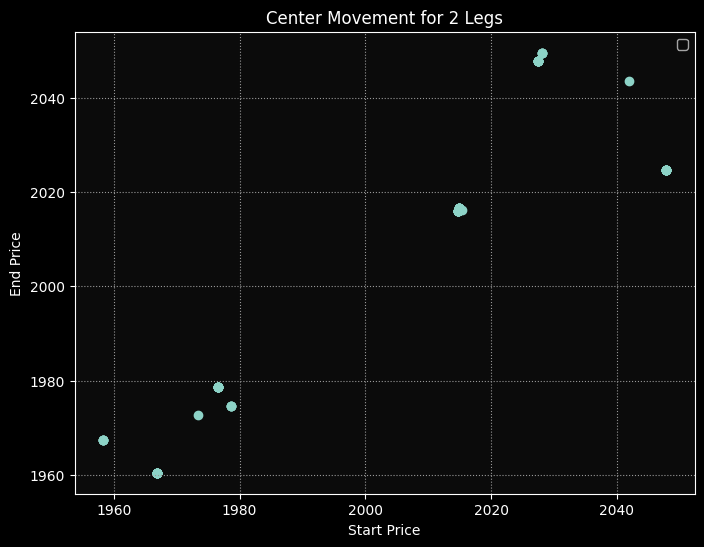

In [91]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.title(f'Center Movement for 2 Legs')
centerHistory1 = np.array(centerHistory1)
plt.scatter(centerHistory1[:, 0], centerHistory1[:, 1])
# plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=100, label='Centers')
plt.xlabel('Start Price')
plt.ylabel('End Price')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

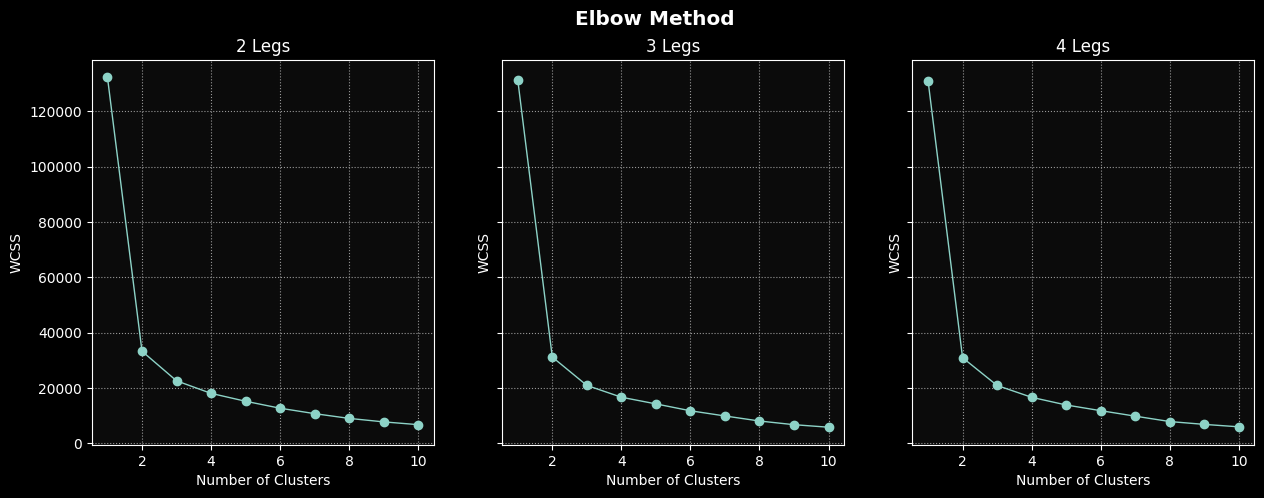

In [101]:
wcss = []

# Find the best hyperparameter using the elbow method
for num_legs, dataset in datasets.items():
    X = dataset[:, 2:4]  # Use only start price and end price for clustering
    wcss_values = []
    for num_clusters in range(1, 11):
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(X)
        wcss_values.append(kmeans.inertia_)
    wcss.append(wcss_values)

# Plot the elbow curve
fig, axs = plt.subplots(1, len(datasets), figsize=(15, 5), sharey=True)
fig.suptitle('Elbow Method')

for i, (num_legs, dataset) in enumerate(datasets.items()):
    axs[i].plot(range(1, 11), wcss[i], marker='o')
    axs[i].set_title(f'{num_legs} Legs')
    axs[i].set_xlabel('Number of Clusters')
    axs[i].set_ylabel('WCSS')

plt.show()


c:\Users\Alireza Nasoodi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Alireza Nasoodi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


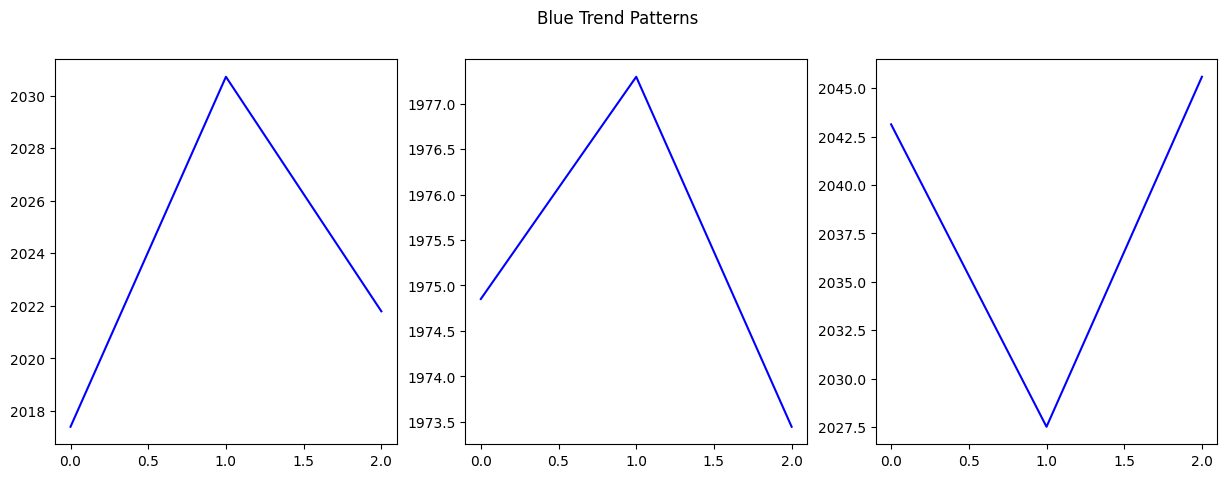

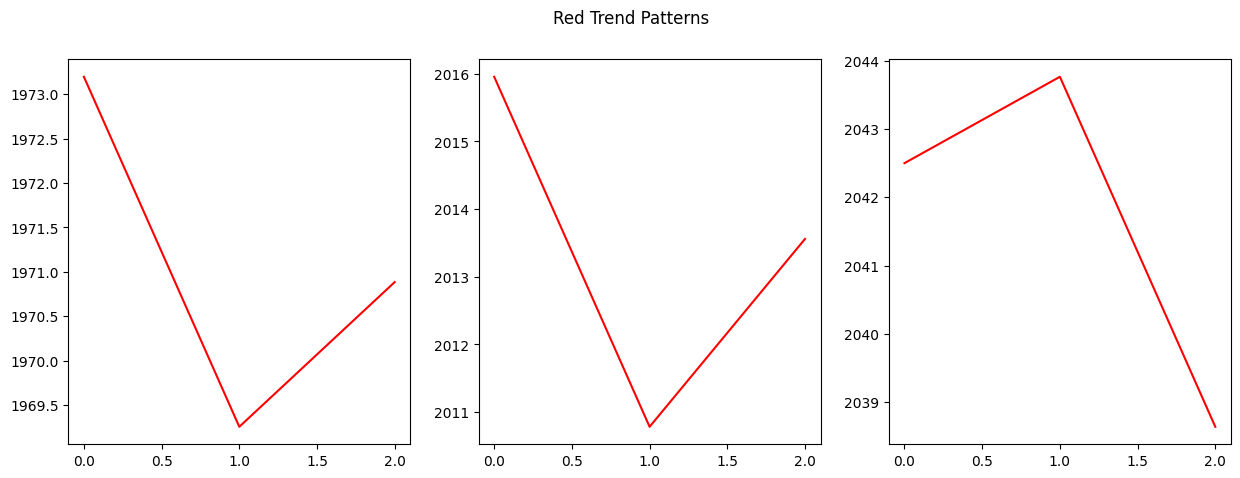

In [33]:
KMeans_imp(2,3,3)

c:\Users\Alireza Nasoodi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Alireza Nasoodi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


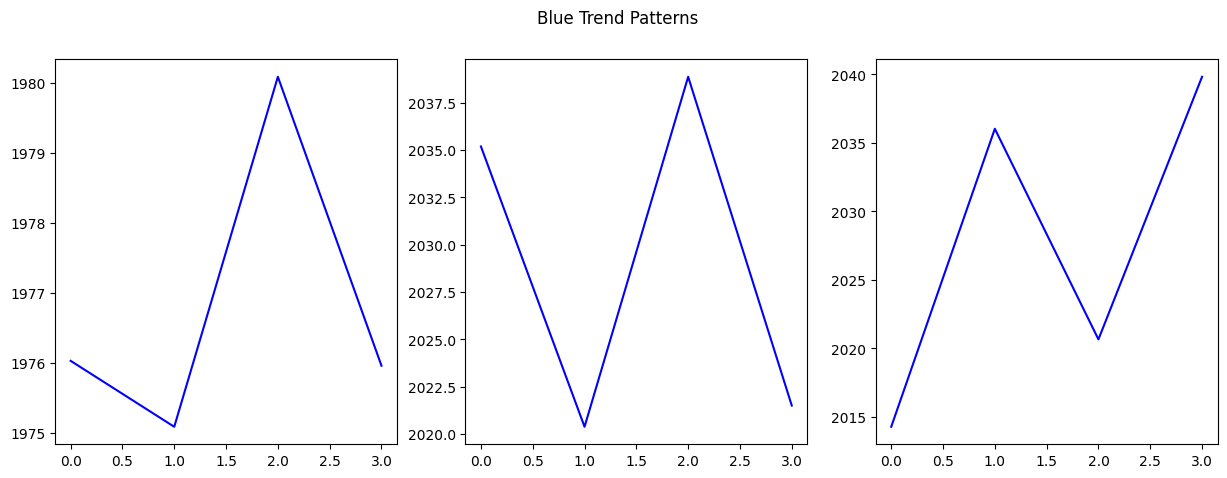

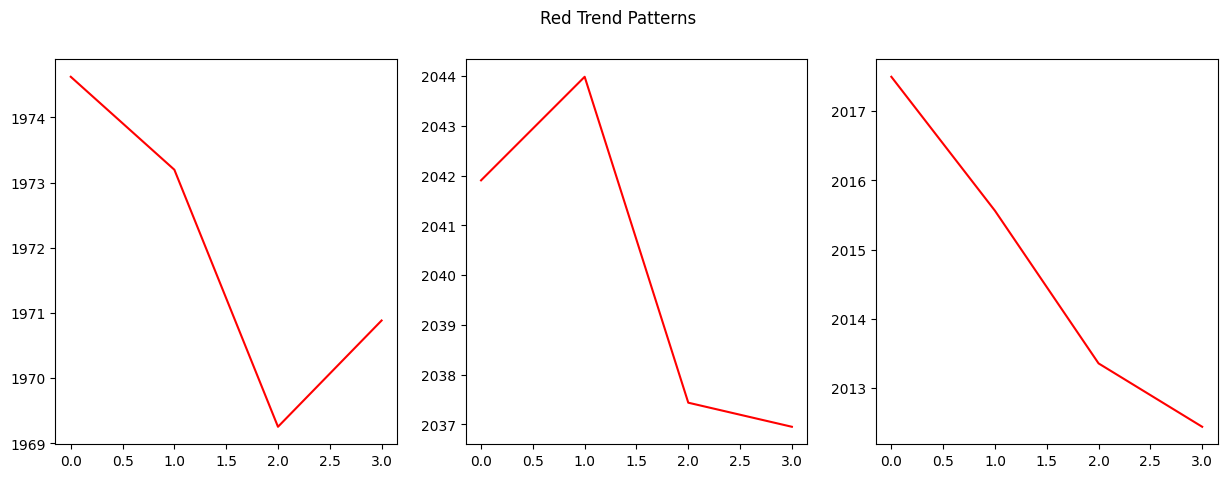

In [34]:
KMeans_imp(3,4,3)

c:\Users\Alireza Nasoodi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Alireza Nasoodi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


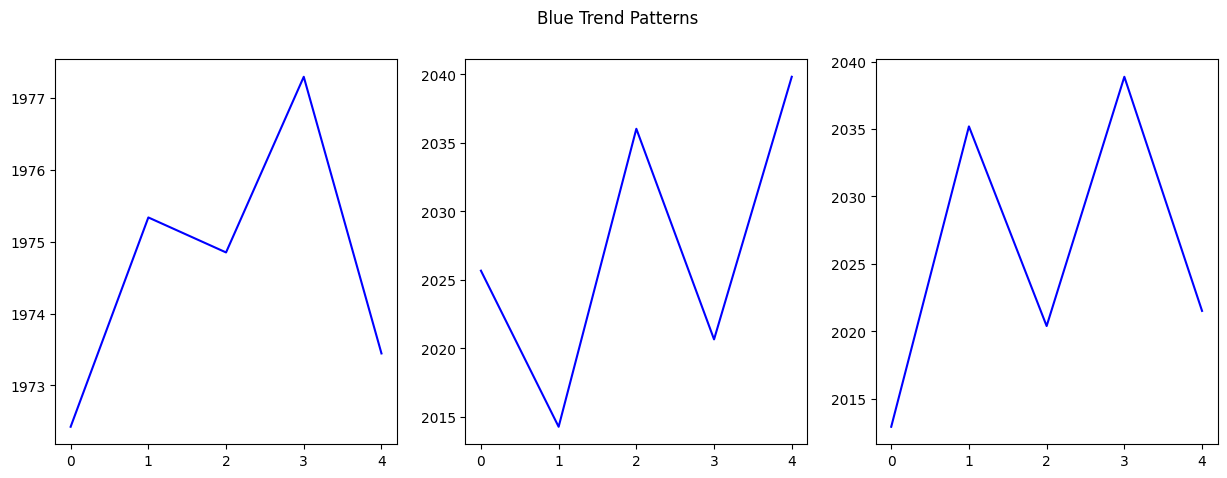

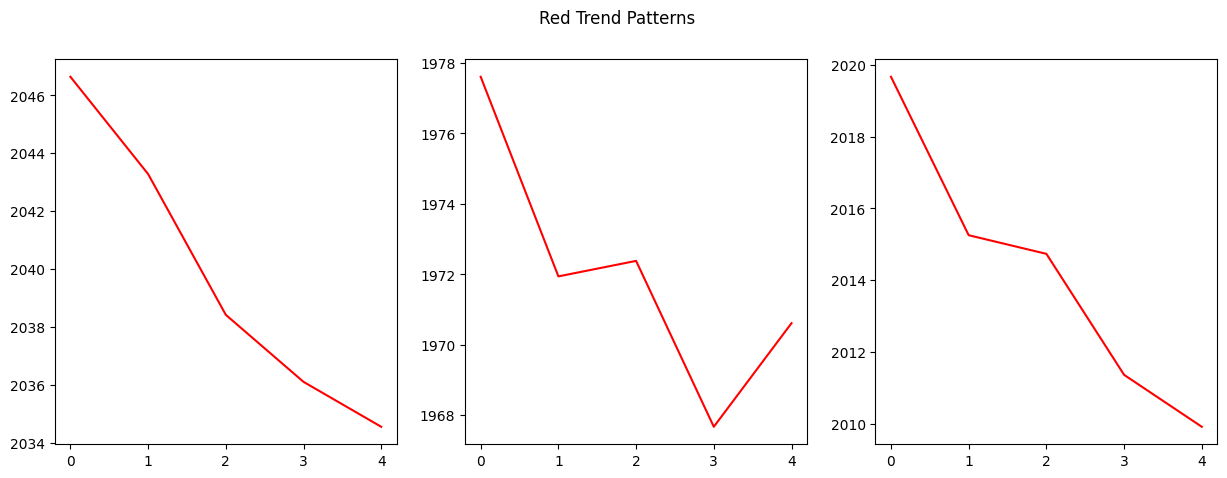

In [35]:
KMeans_imp(4,5,3)

c:\Users\Alireza Nasoodi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


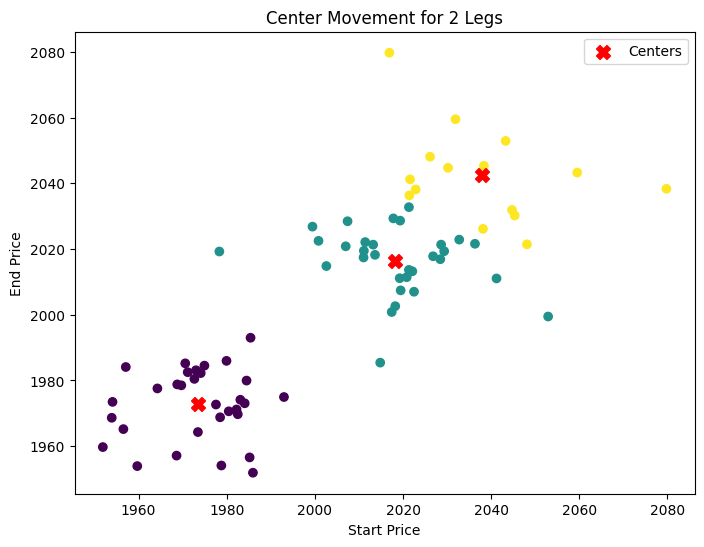

In [145]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

num_clusters = 3

# Run K-means and plot patterns for each dataset
for num_legs, dataset in datasets.items():
    if num_legs == 2:
        # Use only start price and end price for clustering
        X = dataset[:, [0, 2]].astype(float)
        kmeans = KMeans(n_clusters=num_clusters)
        labels = kmeans.fit_predict(X)
        centers = kmeans.cluster_centers_

        # Plot center movement
        plt.figure(figsize=(8, 6))
        plt.title(f'Center Movement for {num_legs} Legs')
        plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
        plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=100, label='Centers')
        plt.xlabel('Start Price')
        plt.ylabel('End Price')
        plt.legend()
        plt.show()
